In [1]:
import numpy as np
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.preprocessing import sequence

%matplotlib inline

C:\Program Files\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from preprocess import divide_to_train_and_test, one_hot
from confusion_matrix import print_confusion_matrix

In [3]:
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"] = '0' #use GPU with ID=0
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5 # maximun alloc gpu50% of MEM
config.gpu_options.allow_growth = True #allocate dynamically
sess = tf.Session(config = config)

In [4]:
def load_from_directory(texts_directory, images_directory, target_names, max_files_in_one_category=30000):
    file_texts = []
    targets = []
    
    for root, dirs, files in os.walk(images_directory):
        number_used_files = 0
        for name in files:
            if number_used_files < max_files_in_one_category:
            
                name_without_extenstion, _ = os.path.splitext(name)
                
                _, cur_target = os.path.split(root)
                cur_target = target_names.index(cur_target)
            
                text_name = name_without_extenstion + ".txt"
                cur_text_path =  os.path.join(texts_directory, text_name)
                
                try:
                    with open(cur_text_path, encoding="utf-16") as file:
                
                        # считываем файл построчно
                        file_text = ""
                        for line in file.readlines():
                            file_text += (line)
                        if file_text != "" and file_text != " ":
                            file_texts.append(file_text[2:])
                            targets.append(cur_target)
                
                            number_used_files += 1            
                except:
                    print("PROBLEM WITH FILE", cur_text_path)
                
    return file_texts, targets


In [5]:
#let's try to write another version of "load_embeddins"

def load_embeddings(emb_path, max_embeddings_count=100000):
    emb_word_id_to_vector = {}
    word_to_id = {}
    current_word_id = 0
    with open(emb_path, 'r', encoding='utf-8') as f:
        for line in f:
            if current_word_id <= max_embeddings_count:
                line_split = line.strip().split(" ")
                word = line_split[0]
                word_emb = np.array(line_split[1:], dtype=float)
            
                if word_emb.shape != (300,):
                    print("ERROR! Shape is", word_emb.shape, word)
                    continue
            
                word_to_id[word] = current_word_id
                emb_word_id_to_vector[current_word_id] = word_emb
                current_word_id += 1
            else:
                break
            
    return emb_word_id_to_vector, word_to_id

In [12]:
CATEGORIES_COUNT = 7

In [6]:
%%time
file_texts, targets = load_from_directory(texts_directory="D:/svruchtel/DATA/France_New/Texts",
                                         images_directory="D:/svruchtel/DATA/France_New_ByMeaning", 
                                         target_names = ["GazolineStation", "Hotel", "Parking", "Restaurant", "Taxi",
                                                        "TollRoad", "Transport"])

Wall time: 361 ms


In [7]:
%%time
emb_word_id_to_vector, word_to_id = load_embeddings("D:/svruchtel/EMBEDDINGS/wiki.fr.vec", 
                                    max_embeddings_count=300000)

ERROR! Shape is (1,) 1152449
ERROR! Shape is (299,) -0.28063
ERROR! Shape is (299,) 0.43353
ERROR! Shape is (299,) -0.0038925
ERROR! Shape is (299,) -0.035726
ERROR! Shape is (299,) -0.20013
ERROR! Shape is (299,) -0.46027
ERROR! Shape is (299,) -0.20699
ERROR! Shape is (299,) 0.2856
ERROR! Shape is (299,) 0.16302
ERROR! Shape is (299,) 0.23343
ERROR! Shape is (299,) -0.02369
ERROR! Shape is (299,) 0.10821
ERROR! Shape is (299,) 0.2008
ERROR! Shape is (299,) 0.18062
ERROR! Shape is (299,) 0.12528
ERROR! Shape is (299,) 0.17735
Wall time: 48.2 s


In [13]:
def change_words_to_their_embeddings(file_texts, emb_word_id_to_vector, word_to_id):
    X_emb = []
    
    for text in file_texts:
        embedded_text = []

        words_count = 0

        words = [word for word in text.strip().replace(":", " ").replace(".", " ").replace("!", " ").replace("?", " ").replace(",", " ").replace(";", " ").replace("\n", " ").split(" ") if word != "" ]
        for word in words:
            if words_count < 200:
                if word in word_to_id:
                    embedded_text.append(emb_word_id_to_vector[word_to_id[word]])
                    words_count += 1
                elif word.lower() in word_to_id:
                    embedded_text.append(emb_word_id_to_vector[word_to_id[word.lower()]])
                    words_count += 1
                else:
                    #embedded_text.append(emb_word_id_to_vector[word_to_id["nul"]])
                    print("There is no embedding for word", word)
            else:
                break

        while words_count < 200:
            embedded_text.append(emb_word_id_to_vector[word_to_id["nul"]])
            words_count += 1
    
        X_emb.append(embedded_text)
    return np.array(X_emb)

In [ ]:
%%time
X_emb = change_words_to_their_embeddings(file_texts, emb_word_id_to_vector, word_to_id)

There is no embedding for word EOUGIVAL
There is no embedding for word 39C
There is no embedding for word 553
There is no embedding for word 339
There is no embedding for word 562
There is no embedding for word l'11e
There is no embedding for word 92000
There is no embedding for word Frarce
There is no embedding for word 37
There is no embedding for word 76
There is no embedding for word 03
There is no embedding for word 50
There is no embedding for word 00
There is no embedding for word 1
There is no embedding for word 324
There is no embedding for word /litre
There is no embedding for word EJR
There is no embedding for word 50
There is no embedding for word 00
There is no embedding for word EJR
There is no embedding for word 50
There is no embedding for word 00
There is no embedding for word 20
There is no embedding for word 00
There is no embedding for word EJR
There is no embedding for word 8
There is no embedding for word 33
There is no embedding for word CN°
There is no embedding

In [10]:
X_emb.shape

(3475, 200, 300)

In [14]:
X_train, targets_train, X_test, targets_test = divide_to_train_and_test(X_emb, targets, num_categories=CATEGORIES_COUNT)
# one-hot encoding for targets
y_train = one_hot(targets_train, classes_count=CATEGORIES_COUNT)
y_test = one_hot(targets_test, classes_count=CATEGORIES_COUNT)

In [15]:
print(X_train[0][0][:5])
print(X_train[1][0][:5])

[-0.099065 -0.06619  -0.40714   0.086281 -0.30915 ]
[-0.24657  -0.077648 -0.5886   -0.1002    0.17622 ]


### LET'S RUN LSTM MODELS

### 1

In [16]:
%%time
# create the model
max_text_length = 200
categories_count = CATEGORIES_COUNT

model = Sequential()
model.add(LSTM(100, input_shape=X_train[0].shape))
model.add(Dense(categories_count, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto')
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=100, callbacks=[callback])

# Final evaluation of the model
test_scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f" % (test_scores[1]))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 707       
Total params: 161,107
Trainable params: 161,107
Non-trainable params: 0
_________________________________________________________________
None
Train on 3123 samples, validate on 352 samples
Epoch 1/200
3123/3123 [==============================] - 16s 5ms/step - loss: 1.6551 - acc: 0.4028 - val_loss: 1.6418 - val_acc: 0.4062
Epoch 2/200
3123/3123 [==============================] - 15s 5ms/step - loss: 1.6252 - acc: 0.4121 - val_loss: 1.6353 - val_acc: 0.4062
Epoch 3/200
3123/3123 [==============================] - 15s 5ms/step - loss: 1.6219 - acc: 0.4121 - val_loss: 1.6346 - val_acc: 0.4062
Epoch 4/200
3123/3123 [==============================] - 15s 5ms/step - 

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[ 304    2    0    1    0    0    2]
 [   0  129    0    1    0    0   23]
 [   3    0  205    1    0    0   27]
 [  13    4    1 1229    1    0    0]
 [   3    0    0    2  232    0    8]
 [   0    0    0    0    0  732    0]
 [   0    0    4    0    1    0  195]]
Normalized confusion matrix
[[9.83818770e-01 6.47249191e-03 0.00000000e+00 3.23624595e-03
  0.00000000e+00 0.00000000e+00 6.47249191e-03]
 [0.00000000e+00 8.43137255e-01 0.00000000e+00 6.53594771e-03
  0.00000000e+00 0.00000000e+00 1.50326797e-01]
 [1.27118644e-02 0.00000000e+00 8.68644068e-01 4.23728814e-03
  0.00000000e+00 0.00000000e+00 1.14406780e-01]
 [1.04166667e-02 3.20512821e-03 8.01282051e-04 9.84775641e-01
  8.01282051e-04 0.00000000e+00 0.00000000e+00]
 [1.22448980e-02 0.00000000e+00 0.00000000e+00 8.16326531e-03
  9.46938776e-01 0.00000000e+00 3.26530612e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+0

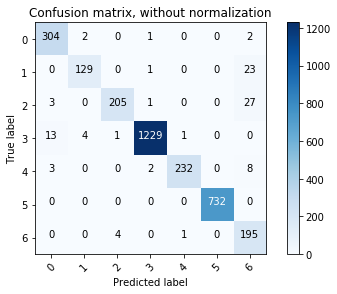

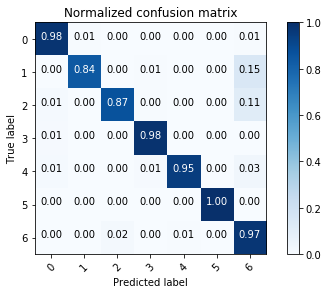

TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[ 35   0   0   0   0   0   0]
 [  0  12   0   0   0   0   6]
 [  0   0  24   0   1   0   2]
 [  3   0   0 134   0   0   2]
 [  0   1   0   1  15   0  11]
 [  1   0   0   0   0  81   0]
 [  0   0   2   0   0   0  21]]
Normalized confusion matrix
[[1.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.66666667 0.         0.         0.         0.
  0.33333333]
 [0.         0.         0.88888889 0.         0.03703704 0.
  0.07407407]
 [0.02158273 0.         0.         0.96402878 0.         0.
  0.01438849]
 [0.         0.03571429 0.         0.03571429 0.53571429 0.
  0.39285714]
 [0.01219512 0.         0.         0.         0.         0.98780488
  0.        ]
 [0.         0.         0.08695652 0.         0.         0.
  0.91304348]]


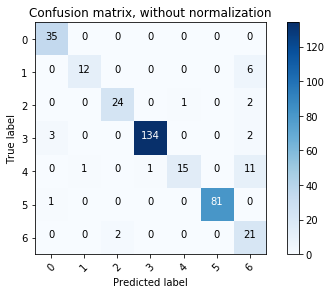

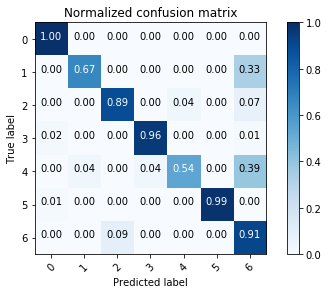

In [17]:
# draw confusion matrix
print("TRAIN CONFUSION MATRIX")
y_pred_train = model.predict(X_train)
print_confusion_matrix(X_train, y_train.argmax(axis=1), y_pred_train.argmax(axis=1), categories_count=CATEGORIES_COUNT)
print("TEST CONFUSION MATRIX")
y_pred_test = model.predict(X_test)
print_confusion_matrix(X_test, y_test.argmax(axis=1), y_pred_test.argmax(axis=1), categories_count=CATEGORIES_COUNT)

In [18]:
print("Val accuracy: %.4f" % (test_scores[1]))

Val accuracy: 0.9148


In [19]:
# predict results and write into file

In [20]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

file_path_train_X = "./LSTM_results_word_emb/France_ByMeaning_1st_net_train_X.npy"
file_path_test_X = "./LSTM_results_word_emb/France_ByMeaning_1st_net_test_X.npy"

file_path_train_y = "./LSTM_results_word_emb/France_ByMeaning_1st_net_train_y.npy"
file_path_test_y = "./LSTM_results_word_emb/France_ByMeaning_1st_net_test_y.npy"

np.save(file_path_train_X, train_predict)
np.save(file_path_test_X, test_predict)
np.save(file_path_train_y, y_train)
np.save(file_path_test_y, y_test)

### 2

In [21]:
%%time
# Lets try one another architecture

categories_count = CATEGORIES_COUNT

model = Sequential()
model.add(LSTM(100, input_shape=X_train[0].shape))
model.add(Dropout(0.2))
model.add(Dense(categories_count, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto')
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=100, callbacks=[callback])

# Final evaluation of the model
test_scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f" % (test_scores[1]))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 707       
Total params: 161,107
Trainable params: 161,107
Non-trainable params: 0
_________________________________________________________________
None
Train on 3123 samples, validate on 352 samples
Epoch 1/200
3123/3123 [==============================] - 23s 7ms/step - loss: 1.6749 - acc: 0.3836 - val_loss: 1.6456 - val_acc: 0.4062
Epoch 2/200
3123/3123 [==============================] - 15s 5ms/step - loss: 1.6369 - acc: 0.4089 - val_loss: 1.6399 - val_acc: 0.4062
Epoch 3/200
3123/3123 [==============================] - 15s 5ms/step - loss

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[ 279    1    0    1    3    0   25]
 [   1  144    0    3    1    0    4]
 [   4    1  203    0    0    9   19]
 [  18    6    6 1216    0    0    2]
 [   1    0    5    0  236    0    3]
 [   0    0    1    0    0  730    1]
 [  10    1    5    0    7    1  176]]
Normalized confusion matrix
[[0.90291262 0.00323625 0.         0.00323625 0.00970874 0.
  0.08090615]
 [0.00653595 0.94117647 0.         0.01960784 0.00653595 0.
  0.02614379]
 [0.01694915 0.00423729 0.86016949 0.         0.         0.03813559
  0.08050847]
 [0.01442308 0.00480769 0.00480769 0.97435897 0.         0.
  0.00160256]
 [0.00408163 0.         0.02040816 0.         0.96326531 0.
  0.0122449 ]
 [0.         0.         0.00136612 0.         0.         0.99726776
  0.00136612]
 [0.05       0.005      0.025      0.         0.035      0.005
  0.88      ]]


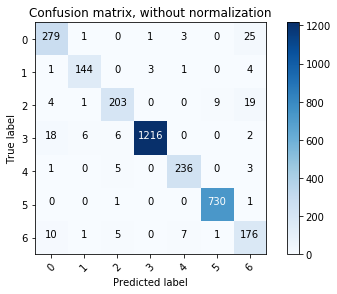

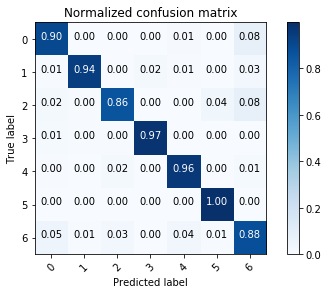

TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[ 34   0   0   0   0   0   1]
 [  0  15   0   1   0   0   2]
 [  0   0  24   1   0   0   2]
 [  4   0   1 134   0   0   0]
 [  0   1   0   1  26   0   0]
 [  0   0   1   0   0  81   0]
 [  0   0   5   0   1   0  17]]
Normalized confusion matrix
[[0.97142857 0.         0.         0.         0.         0.
  0.02857143]
 [0.         0.83333333 0.         0.05555556 0.         0.
  0.11111111]
 [0.         0.         0.88888889 0.03703704 0.         0.
  0.07407407]
 [0.02877698 0.         0.00719424 0.96402878 0.         0.
  0.        ]
 [0.         0.03571429 0.         0.03571429 0.92857143 0.
  0.        ]
 [0.         0.         0.01219512 0.         0.         0.98780488
  0.        ]
 [0.         0.         0.2173913  0.         0.04347826 0.
  0.73913043]]


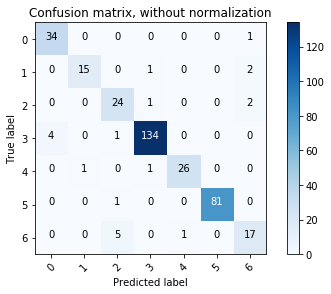

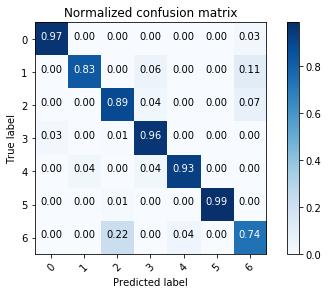

In [22]:
# draw confusion matrix
print("TRAIN CONFUSION MATRIX")
y_pred_train = model.predict(X_train)
print_confusion_matrix(X_train, y_train.argmax(axis=1), y_pred_train.argmax(axis=1), categories_count=CATEGORIES_COUNT)
print("TEST CONFUSION MATRIX")
y_pred_test = model.predict(X_test)
print_confusion_matrix(X_test, y_test.argmax(axis=1), y_pred_test.argmax(axis=1), categories_count=CATEGORIES_COUNT)

In [23]:
print("Val accuracy: %.4f" % (test_scores[1]))

Val accuracy: 0.9403


In [24]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

file_path_train_X = "./LSTM_results_word_emb/France_ByMeaning_2nd_net_train_X.npy"
file_path_test_X = "./LSTM_results_word_emb/France_ByMeaning_2nd_net_test_X.npy"

file_path_train_y = "./LSTM_results_word_emb/France_ByMeaning_2nd_net_train_y.npy"
file_path_test_y = "./LSTM_results_word_emb/France_ByMeaning_2nd_net_test_y.npy"

np.save(file_path_train_X, train_predict)
np.save(file_path_test_X, test_predict)
np.save(file_path_train_y, y_train)
np.save(file_path_test_y, y_test)

### 3

In [25]:
%%time

categories_count = CATEGORIES_COUNT

model = Sequential()
model.add(LSTM(100, input_shape=X_train[0].shape, recurrent_dropout=0.2))
model.add(Dense(categories_count, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto')
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=100, callbacks=[callback])

# Final evaluation of the model
test_scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f" % (test_scores[1]))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 707       
Total params: 161,107
Trainable params: 161,107
Non-trainable params: 0
_________________________________________________________________
None
Train on 3123 samples, validate on 352 samples
Epoch 1/200
3123/3123 [==============================] - 19s 6ms/step - loss: 1.6638 - acc: 0.3999 - val_loss: 1.6621 - val_acc: 0.4062
Epoch 2/200
3123/3123 [==============================] - 17s 6ms/step - loss: 1.6336 - acc: 0.4118 - val_loss: 1.6395 - val_acc: 0.4062
Epoch 3/200
3123/3123 [==============================] - 17s 5ms/step - loss: 1.6213 - acc: 0.4121 - val_loss: 1.6337 - val_acc: 0.4062
Epoch 4/200
3123/3123 [==============================] - 17s 6ms/step - 

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[ 303    0    1    5    0    0    0]
 [   0  139    0   14    0    0    0]
 [   0    0  233    1    0    0    2]
 [   1    1    1 1245    0    0    0]
 [   0    1    1    0  240    0    3]
 [   0    0    0    0    0  732    0]
 [   0    0    0    2    1    0  197]]
Normalized confusion matrix
[[9.80582524e-01 0.00000000e+00 3.23624595e-03 1.61812298e-02
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 9.08496732e-01 0.00000000e+00 9.15032680e-02
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.87288136e-01 4.23728814e-03
  0.00000000e+00 0.00000000e+00 8.47457627e-03]
 [8.01282051e-04 8.01282051e-04 8.01282051e-04 9.97596154e-01
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 4.08163265e-03 4.08163265e-03 0.00000000e+00
  9.79591837e-01 0.00000000e+00 1.22448980e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+0

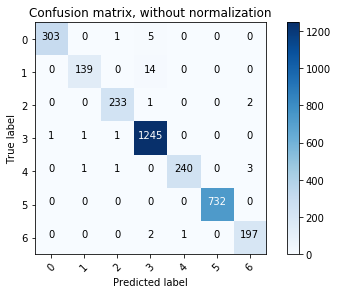

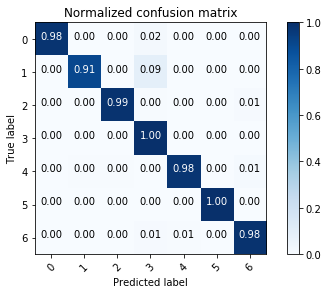

TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[ 34   0   0   1   0   0   0]
 [  0  13   0   5   0   0   0]
 [  0   0  25   0   0   0   2]
 [  0   0   1 138   0   0   0]
 [  0   2   0   1  24   0   1]
 [  0   0   1   0   0  81   0]
 [  0   0   2   0   0   0  21]]
Normalized confusion matrix
[[0.97142857 0.         0.         0.02857143 0.         0.
  0.        ]
 [0.         0.72222222 0.         0.27777778 0.         0.
  0.        ]
 [0.         0.         0.92592593 0.         0.         0.
  0.07407407]
 [0.         0.         0.00719424 0.99280576 0.         0.
  0.        ]
 [0.         0.07142857 0.         0.03571429 0.85714286 0.
  0.03571429]
 [0.         0.         0.01219512 0.         0.         0.98780488
  0.        ]
 [0.         0.         0.08695652 0.         0.         0.
  0.91304348]]


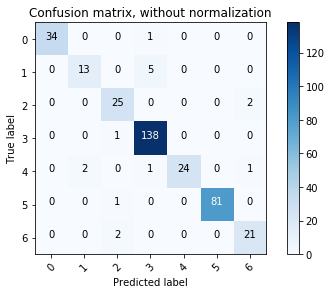

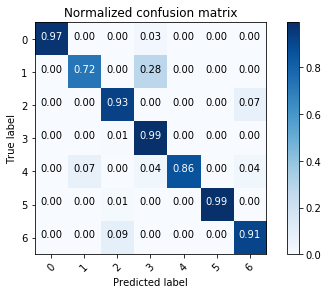

In [26]:
# draw confusion matrix
print("TRAIN CONFUSION MATRIX")
y_pred_train = model.predict(X_train)
print_confusion_matrix(X_train, y_train.argmax(axis=1), y_pred_train.argmax(axis=1), categories_count=CATEGORIES_COUNT)
print("TEST CONFUSION MATRIX")
y_pred_test = model.predict(X_test)
print_confusion_matrix(X_test, y_test.argmax(axis=1), y_pred_test.argmax(axis=1), categories_count=CATEGORIES_COUNT)

In [27]:
print("Val accuracy: %.4f" % (test_scores[1]))

Val accuracy: 0.9545


In [28]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

file_path_train_X = "./LSTM_results_word_emb/France_ByMeaning_3rd_net_train_X.npy"
file_path_test_X = "./LSTM_results_word_emb/France_ByMeaning_3rd_net_test_X.npy"

file_path_train_y = "./LSTM_results_word_emb/France_ByMeaning_3rd_net_train_y.npy"
file_path_test_y = "./LSTM_results_word_emb/France_ByMeaning_3rd_net_test_y.npy"

np.save(file_path_train_X, train_predict)
np.save(file_path_test_X, test_predict)
np.save(file_path_train_y, y_train)
np.save(file_path_test_y, y_test)

### 4

In [29]:
%%time
# and two LSTM's

categories_count = CATEGORIES_COUNT

model = Sequential()
model.add(LSTM(100, input_shape=X_train[0].shape, recurrent_dropout=0.4, return_sequences=True))
model.add(LSTM(200, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(categories_count, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto')
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=100, callbacks=[callback])

# Final evaluation of the model
test_scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f" % (test_scores[1]))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 200, 100)          160400    
_________________________________________________________________
lstm_5 (LSTM)                (None, 200)               240800    
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 1407      
Total params: 402,607
Trainable params: 402,607
Non-trainable params: 0
_________________________________________________________________
None
Train on 3123 samples, validate on 352 samples
Epoch 1/200
3123/3123 [==============================] - 45s 14ms/step - loss: 1.6749 - acc: 0.3910 - val_loss: 1.6444 - val_acc: 0.4062
Epoch 2/200
3123/3123 [==============================] - 42s 13ms/step - loss: 1.6269 - acc: 0.4124 - val_loss: 1.6301 - val_acc: 0.4062
Epoch 3/200
3123/3123 [==============================] - 58s 18ms/step - l

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[ 291    0   12    3    0    0    3]
 [   0  135    0   10    0    0    8]
 [   0    0  203    0    6    0   27]
 [   3    1    4 1236    0    0    4]
 [   0    0    2    0  228    0   15]
 [   0    0    0    0    2  729    1]
 [   0    2    0    0    6    0  192]]
Normalized confusion matrix
[[9.41747573e-01 0.00000000e+00 3.88349515e-02 9.70873786e-03
  0.00000000e+00 0.00000000e+00 9.70873786e-03]
 [0.00000000e+00 8.82352941e-01 0.00000000e+00 6.53594771e-02
  0.00000000e+00 0.00000000e+00 5.22875817e-02]
 [0.00000000e+00 0.00000000e+00 8.60169492e-01 0.00000000e+00
  2.54237288e-02 0.00000000e+00 1.14406780e-01]
 [2.40384615e-03 8.01282051e-04 3.20512821e-03 9.90384615e-01
  0.00000000e+00 0.00000000e+00 3.20512821e-03]
 [0.00000000e+00 0.00000000e+00 8.16326531e-03 0.00000000e+00
  9.30612245e-01 0.00000000e+00 6.12244898e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.73224044e-03 9.95901639e-0

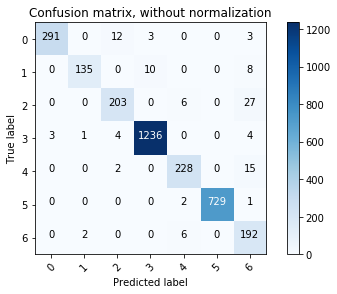

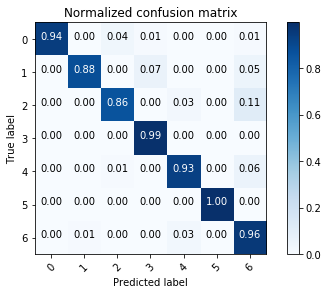

TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[ 32   0   2   0   0   0   1]
 [  1  13   0   1   1   0   2]
 [  1   0  21   0   1   0   4]
 [  0   0   0 137   0   0   2]
 [  0   0   0   1  26   0   1]
 [  0   0   0   0   0  80   2]
 [  0   0   2   0   0   0  21]]
Normalized confusion matrix
[[0.91428571 0.         0.05714286 0.         0.         0.
  0.02857143]
 [0.05555556 0.72222222 0.         0.05555556 0.05555556 0.
  0.11111111]
 [0.03703704 0.         0.77777778 0.         0.03703704 0.
  0.14814815]
 [0.         0.         0.         0.98561151 0.         0.
  0.01438849]
 [0.         0.         0.         0.03571429 0.92857143 0.
  0.03571429]
 [0.         0.         0.         0.         0.         0.97560976
  0.02439024]
 [0.         0.         0.08695652 0.         0.         0.
  0.91304348]]


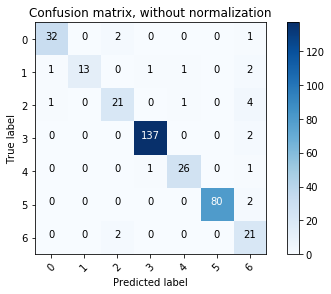

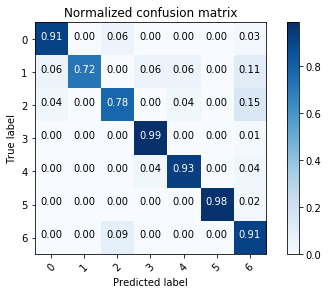

In [30]:
# draw confusion matrix
print("TRAIN CONFUSION MATRIX")
y_pred_train = model.predict(X_train)
print_confusion_matrix(X_train, y_train.argmax(axis=1), y_pred_train.argmax(axis=1), categories_count=CATEGORIES_COUNT)
print("TEST CONFUSION MATRIX")
y_pred_test = model.predict(X_test)
print_confusion_matrix(X_test, y_test.argmax(axis=1), y_pred_test.argmax(axis=1), categories_count=CATEGORIES_COUNT)

In [31]:
print("Val accuracy: %.4f" % (test_scores[1]))

Val accuracy: 0.9375


In [32]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

file_path_train_X = "./LSTM_results_word_emb/France_ByMeaning_4th_net_train_X.npy"
file_path_test_X = "./LSTM_results_word_emb/France_ByMeaning_4th_net_test_X.npy"

file_path_train_y = "./LSTM_results_word_emb/France_ByMeaning_4th_net_train_y.npy"
file_path_test_y = "./LSTM_results_word_emb/France_ByMeaning_4th_net_test_y.npy"

np.save(file_path_train_X, train_predict)
np.save(file_path_test_X, test_predict)
np.save(file_path_train_y, y_train)
np.save(file_path_test_y, y_test)

### 5

In [33]:
%%time
# and also with 1d-convolutional layer

categories_count = CATEGORIES_COUNT

model = Sequential()
model.add(Conv1D(input_shape=X_train[0].shape, filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(categories_count, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto')
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=100, callbacks=[callback])

# Final evaluation of the model
test_scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f" % (test_scores[1]))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 200, 32)           28832     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 100, 32)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 707       
Total params: 82,739
Trainable params: 82,739
Non-trainable params: 0
_________________________________________________________________
None
Train on 3123 samples, validate on 352 samples
Epoch 1/200
3123/3123 [==============================] - 14s 4ms/step - loss: 1.6684 - acc: 0.4012 - val_loss: 1.6364 - val_acc: 0.4062
Epoch 2/200
3123/3123 [==============================] - 11s 4ms/step - loss: 1.62

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[ 307    0    0    1    0    0    1]
 [   0  139    0    1    1    0   12]
 [   1    0  206    1    1    0   27]
 [   1    2    4 1239    0    0    2]
 [   0    0    3    0  225    0   17]
 [   0    0   67    0    0  665    0]
 [   2    1    6    0   19    0  172]]
Normalized confusion matrix
[[9.93527508e-01 0.00000000e+00 0.00000000e+00 3.23624595e-03
  0.00000000e+00 0.00000000e+00 3.23624595e-03]
 [0.00000000e+00 9.08496732e-01 0.00000000e+00 6.53594771e-03
  6.53594771e-03 0.00000000e+00 7.84313725e-02]
 [4.23728814e-03 0.00000000e+00 8.72881356e-01 4.23728814e-03
  4.23728814e-03 0.00000000e+00 1.14406780e-01]
 [8.01282051e-04 1.60256410e-03 3.20512821e-03 9.92788462e-01
  0.00000000e+00 0.00000000e+00 1.60256410e-03]
 [0.00000000e+00 0.00000000e+00 1.22448980e-02 0.00000000e+00
  9.18367347e-01 0.00000000e+00 6.93877551e-02]
 [0.00000000e+00 0.00000000e+00 9.15300546e-02 0.00000000e+00
  0.00000000e+00 9.08469945e-0

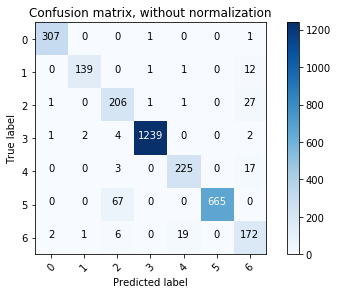

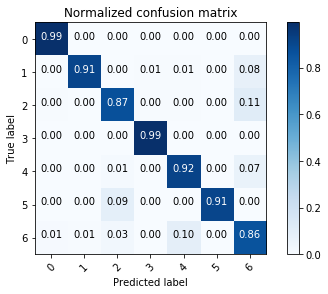

TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[ 35   0   0   0   0   0   0]
 [  1  12   0   1   0   0   4]
 [  0   0  22   0   1   0   4]
 [  2   1   0 135   0   0   1]
 [  1   0   0   0  21   0   6]
 [  0   0  14   0   0  67   1]
 [  0   0   8   0   4   0  11]]
Normalized confusion matrix
[[1.         0.         0.         0.         0.         0.
  0.        ]
 [0.05555556 0.66666667 0.         0.05555556 0.         0.
  0.22222222]
 [0.         0.         0.81481481 0.         0.03703704 0.
  0.14814815]
 [0.01438849 0.00719424 0.         0.97122302 0.         0.
  0.00719424]
 [0.03571429 0.         0.         0.         0.75       0.
  0.21428571]
 [0.         0.         0.17073171 0.         0.         0.81707317
  0.01219512]
 [0.         0.         0.34782609 0.         0.17391304 0.
  0.47826087]]


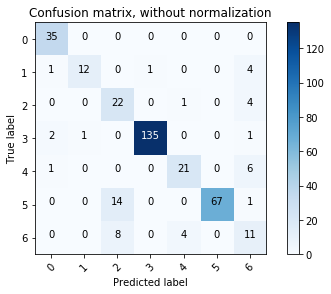

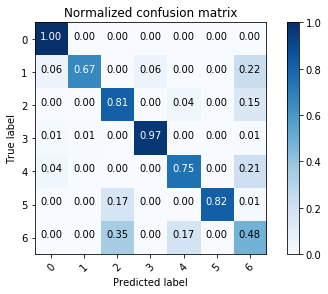

In [34]:
# draw confusion matrix
print("TRAIN CONFUSION MATRIX")
y_pred_train = model.predict(X_train)
print_confusion_matrix(X_train, y_train.argmax(axis=1), y_pred_train.argmax(axis=1), categories_count=CATEGORIES_COUNT)
print("TEST CONFUSION MATRIX")
y_pred_test = model.predict(X_test)
print_confusion_matrix(X_test, y_test.argmax(axis=1), y_pred_test.argmax(axis=1), categories_count=CATEGORIES_COUNT)

In [35]:
print("Val accuracy: %.4f" % (test_scores[1]))

Val accuracy: 0.8608


In [36]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

file_path_train_X = "./LSTM_results_word_emb/France_ByMeaning_5th_net_train_X.npy"
file_path_test_X = "./LSTM_results_word_emb/France_ByMeaning_5th_net_test_X.npy"

file_path_train_y = "./LSTM_results_word_emb/France_ByMeaning_5th_net_train_y.npy"
file_path_test_y = "./LSTM_results_word_emb/France_ByMeaning_5th_net_test_y.npy"

np.save(file_path_train_X, train_predict)
np.save(file_path_test_X, test_predict)
np.save(file_path_train_y, y_train)
np.save(file_path_test_y, y_test)

### 6

In [37]:
%%time

categories_count = CATEGORIES_COUNT

model = Sequential()
model.add(Conv1D(input_shape=X_train[0].shape, filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100, recurrent_dropout=0.2))
model.add(Dense(categories_count, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto')
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=100, callbacks=[callback])

# Final evaluation of the model
test_scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f" % (test_scores[1]))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 200, 32)           28832     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 100, 32)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_6 (Dense)              (None, 7)                 707       
Total params: 82,739
Trainable params: 82,739
Non-trainable params: 0
_________________________________________________________________
None
Train on 3123 samples, validate on 352 samples
Epoch 1/200
3123/3123 [==============================] - 14s 4ms/step - loss: 1.6737 - acc: 0.3926 - val_loss: 1.6329 - val_acc: 0.4062
Epoch 2/200
3123/3123 [==============================] - 12s 4ms/step - loss: 1.61

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[ 308    0    0    1    0    0    0]
 [   0  150    0    0    3    0    0]
 [   1    1  222    0    0    0   12]
 [   2    1    4 1241    0    0    0]
 [   0    0    3    0  239    0    3]
 [   0    0    0    0    0  732    0]
 [   0    3    6    0    3    0  188]]
Normalized confusion matrix
[[9.96763754e-01 0.00000000e+00 0.00000000e+00 3.23624595e-03
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 9.80392157e-01 0.00000000e+00 0.00000000e+00
  1.96078431e-02 0.00000000e+00 0.00000000e+00]
 [4.23728814e-03 4.23728814e-03 9.40677966e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 5.08474576e-02]
 [1.60256410e-03 8.01282051e-04 3.20512821e-03 9.94391026e-01
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.22448980e-02 0.00000000e+00
  9.75510204e-01 0.00000000e+00 1.22448980e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+0

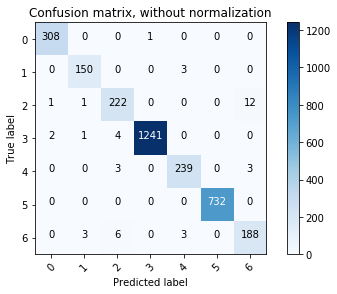

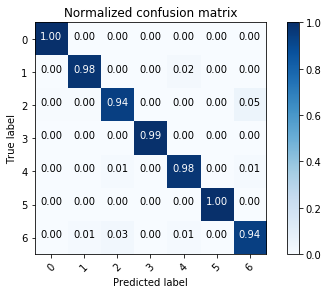

TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[ 33   0   0   1   1   0   0]
 [  1  14   0   3   0   0   0]
 [  0   0  17   1   0   0   9]
 [  1   0   0 138   0   0   0]
 [  0   2   0   2  23   0   1]
 [  1   0   0   0   0  81   0]
 [  0   0   5   0   1   0  17]]
Normalized confusion matrix
[[0.94285714 0.         0.         0.02857143 0.02857143 0.
  0.        ]
 [0.05555556 0.77777778 0.         0.16666667 0.         0.
  0.        ]
 [0.         0.         0.62962963 0.03703704 0.         0.
  0.33333333]
 [0.00719424 0.         0.         0.99280576 0.         0.
  0.        ]
 [0.         0.07142857 0.         0.07142857 0.82142857 0.
  0.03571429]
 [0.01219512 0.         0.         0.         0.         0.98780488
  0.        ]
 [0.         0.         0.2173913  0.         0.04347826 0.
  0.73913043]]


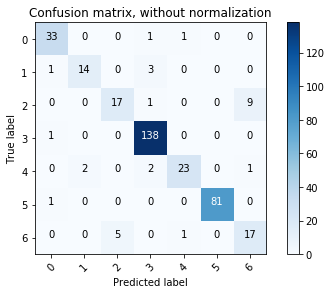

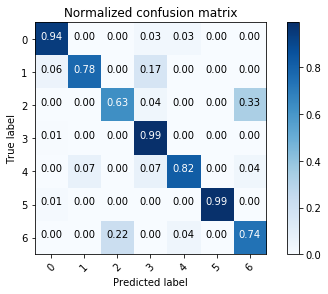

In [38]:
# draw confusion matrix
print("TRAIN CONFUSION MATRIX")
y_pred_train = model.predict(X_train)
print_confusion_matrix(X_train, y_train.argmax(axis=1), y_pred_train.argmax(axis=1), categories_count=CATEGORIES_COUNT)
print("TEST CONFUSION MATRIX")
y_pred_test = model.predict(X_test)
print_confusion_matrix(X_test, y_test.argmax(axis=1), y_pred_test.argmax(axis=1), categories_count=CATEGORIES_COUNT)

In [39]:
print("Val accuracy: %.4f" % (test_scores[1]))

Val accuracy: 0.9176


In [40]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

file_path_train_X = "./LSTM_results_word_emb/France_ByMeaning_6th_net_train_X.npy"
file_path_test_X = "./LSTM_results_word_emb/France_ByMeaning_6th_net_test_X.npy"

file_path_train_y = "./LSTM_results_word_emb/France_ByMeaning_6th_net_train_y.npy"
file_path_test_y = "./LSTM_results_word_emb/France_ByMeaning_6th_net_test_y.npy"

np.save(file_path_train_X, train_predict)
np.save(file_path_test_X, test_predict)
np.save(file_path_train_y, y_train)
np.save(file_path_test_y, y_test)